# IS318 - Machine Learning

## TP3 - SVM and bag of features

In this TP, we will experiment with SVM classifiers. We will also work with K-Means clustering. We will apply these methods to a classical image classification approach called **bag of features**.

In [1]:
import sklearn
import sklearn.cluster
import sklearn.datasets
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import skimage.feature
import skimage.io
from sklearn.svm import SVC

import numpy as np
import matplotlib.pyplot as plt

from skimage import exposure

np.random.seed(42)

### 1. Introduction to SVM

In `scikit-learn` there exists several implementations of SVM. In this TP, we will use the `sklearn.svm.SVC` version, which allows to easily change the kernel used.

We will work a dataset of small images of faces called **Olivetti faces**. It is composed of 400 images of size 64x64, depicting 40 different persons.

In [2]:
olivetti_faces_dataset = sklearn.datasets.fetch_olivetti_faces()

**(Question)** Access the images and labels and set up an appropriate cross validation protocol.

X shape: (400, 4096)
y shape: (400,)
10 random faces wih their labels:


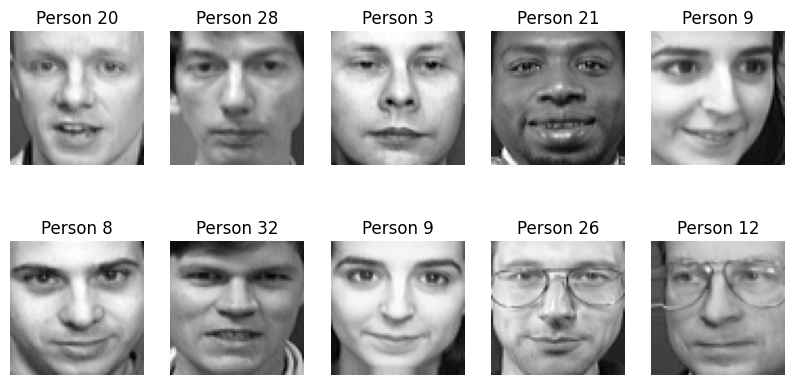

Number of unique people: 40


In [3]:
X = olivetti_faces_dataset.data
y = olivetti_faces_dataset.target

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# X is composed of 400 images of size 64x64

# Show the first 10 faces
print("10 random faces wih their labels:")
plt.figure(figsize=(10, 5))
random_indexes = np.random.choice(X.shape[0], size=10, replace=False)
for i, image_index in enumerate(random_indexes):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[image_index], cmap=plt.cm.gray)
    plt.title(f"Person {y[image_index]}")
    plt.axis('off')
plt.show()
unique_y = len(np.unique(y))
print(f"Number of unique people: {unique_y}")
# Y is composed of the id of 40 different people

# Split the data into training and testing sets

train_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, random_state=42)

# Normalize the data

X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)

X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

assert np.allclose(X_train.mean(axis=0), 0., atol=1e-5)
assert np.allclose(X_train.var(axis=0), 1., atol=1e-5)

**(Question)** Train a multi-class linear SVM classifier on this dataset with your cross-validation protocol. Report the classification accuracy on the validation/test set(s).

In [4]:
n_splits = 10
cross_validator = KFold(n_splits=10)

classifier = SVC() # All default parameters (kernel='rbf', C=1.0, ...)
# classifier = SVC(kernel='linear', C=0.1)

def run_cross_validation(X, y, cross_validator, model):
  scores = []
  for train_index, val_index in cross_validator.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model.fit(X_train, y_train)
    score = model.score(X_val, y_val)
    scores.append(score)

  return scores

scores = run_cross_validation(X_train, y_train, cross_validator, classifier)
print(f"Cross-validation scores: {scores}")
print(f"RBF SVM 10 folds mean accuracy: {np.mean(scores) * 100:.2f}% +-{np.std(scores) * 100:.2f}%")

# Final evaluation on the test set
classifier.fit(X_train, y_train)
score_test_pred = classifier.score(X_test, y_test)
print(f"RBF SVM accuracy on test set: {score_test_pred * 100:.2f}%") 

Cross-validation scores: [0.90625, 0.90625, 0.875, 0.875, 0.78125, 0.875, 0.84375, 0.9375, 0.875, 0.8125]
RBF SVM 10 folds mean accuracy: 86.88% +-4.38%
RBF SVM accuracy on test set: 95.00%


**(Question)** Experiment with different hyperparameters (notably the soft margin parameter $C$) and different kernels. Compare the results.

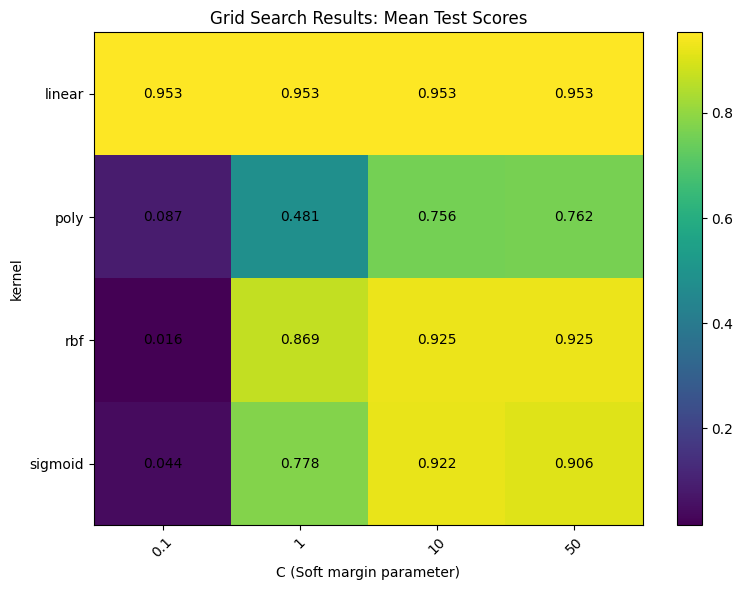

Best parameters: {'C': 0.1, 'kernel': 'linear'}
Best score: 0.953125


In [5]:
grid_search_params = {
    'C' : [0.1, 1, 10, 50],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
}
param1_size = len(grid_search_params['C'])
param2_size = len(grid_search_params['kernel'])

classifier = SVC()
grid_search = GridSearchCV(classifier, grid_search_params, cv=cross_validator)
grid_search.fit(X_train, y_train)

# Plotting the results of the grid search
scores = grid_search.cv_results_['mean_test_score'].reshape(param1_size, param2_size).T

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(scores, cmap='viridis', aspect='auto')
fig.colorbar(cax)
ax.set_xticks(np.arange(param1_size))
ax.set_yticks(np.arange(param2_size))
ax.set_xticklabels(grid_search_params['C'])
ax.set_yticklabels(grid_search_params['kernel'])
plt.xticks(rotation=45)
for i in range(param2_size):
    for j in range(param1_size):
        ax.text(j, i, f'{scores[i, j]:.3f}', ha='center', va='center', color='black')
ax.set_xlabel('C (Soft margin parameter)')
ax.set_ylabel('kernel')
ax.set_title('Grid Search Results: Mean Test Scores')
plt.tight_layout()
plt.show()

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

The linear model appears to be the most reliable for this classification task, achieving an average test classification score of 95.3%, regardless of the soft margin value. Although the RBF and Sigmoid kernels also produce respectable results with soft margin values of 10 and above, achieving scores of 92.5% and 92.2%, respectively.

### 2. Scenes dataset

For the rest of the TP, to experiment with bag of features, we will work with the 8-scenes dataset originally from: https://people.csail.mit.edu/torralba/code/spatialenvelope/

It is provided as an archive file with this TP.

The function below can be used to load the dataset images and labels:

In [6]:
def load_scenes():
    '''Return images and labels of the scenes dataset.'''
    images = skimage.io.ImageCollection('scenes/*.jpg')
    labels_names = [f.split('/')[-1].split('_')[0] for f in images.files]
    unique_labels = sorted(list(set(labels_names)))
    labels_dict = {label: i + 1 for (i, label) in enumerate(unique_labels)}
    labels = np.array([labels_dict[label] for label in labels_names])
    return images, labels

**(Question)** Load the dataset and display some images of the different classes.

10 random scenes wih their labels:


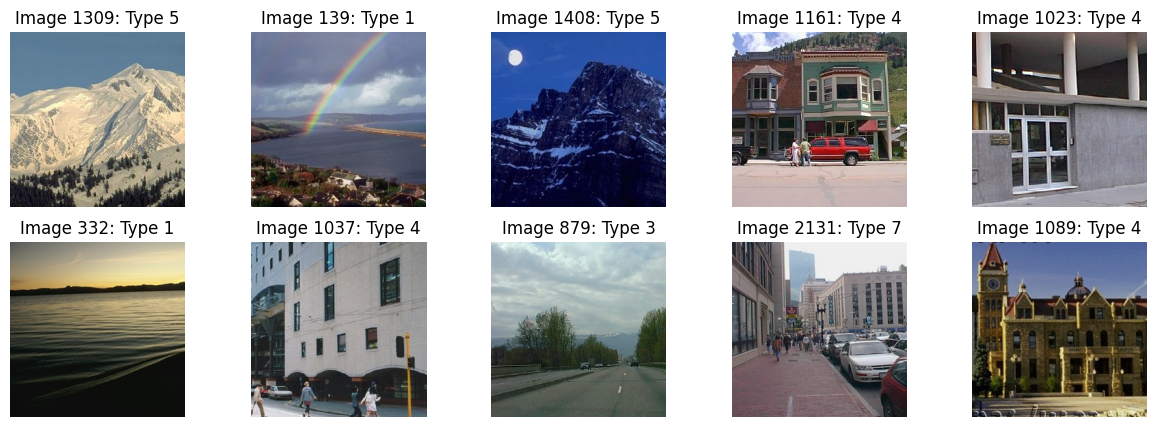

In [7]:
images, labels = load_scenes()

# Show the first 10 scenes
print("10 random scenes wih their labels:")
plt.figure(figsize=(15, 5))
random_indexes = np.random.choice(len(images), size=10, replace=False)
for i, image_index in enumerate(random_indexes):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[image_index], cmap=plt.cm.gray)
    plt.title(f"Image {image_index}: Type {labels[image_index]}")
    plt.axis('off')
plt.show()

### 3. HOG features

Instead of working directly with image pixels (which would represent almost 200k dimensional features), we will be using an image feature descriptor called the Histogram of Oriented Gradients (HOG).

The principle of HOG is to compute a feature vector on several subregions of the image (called patches) for example of size 8x8. The image is then represented as a set of feature vectors corresponding to all patches.

The feature vectors computed are histograms of gradient orientations: the gradient of the image is computed (corresponding to its changes of intensity in each pixel), then the orientations of this gradient in each patch are accumulated into bins (here, we will be using 9 bins per patch).

In computer vision, HOG features are heavily related with the other well-known SIFT keypoints.

In [8]:
def hog_features(image, visualize=False):
    # Return a list of HOG features for a given image
    features = skimage.feature.hog(image, pixels_per_cell=(8, 8), cells_per_block=(1, 1),
                                   block_norm='L2-Hys', feature_vector=False, channel_axis=-1, visualize=visualize)
    if visualize:
        return features[1]
    features = features.reshape(-1, features.shape[-1])
    return features

**(Question)** Compute HOG features for some images. Take a look at the feature vectors obtained and try to understand what the dimensions correspond to.

Original image shape : (256, 256, 3)
HOG feature shape : (1024, 9)
10 random scenes with their labels and HOG features:


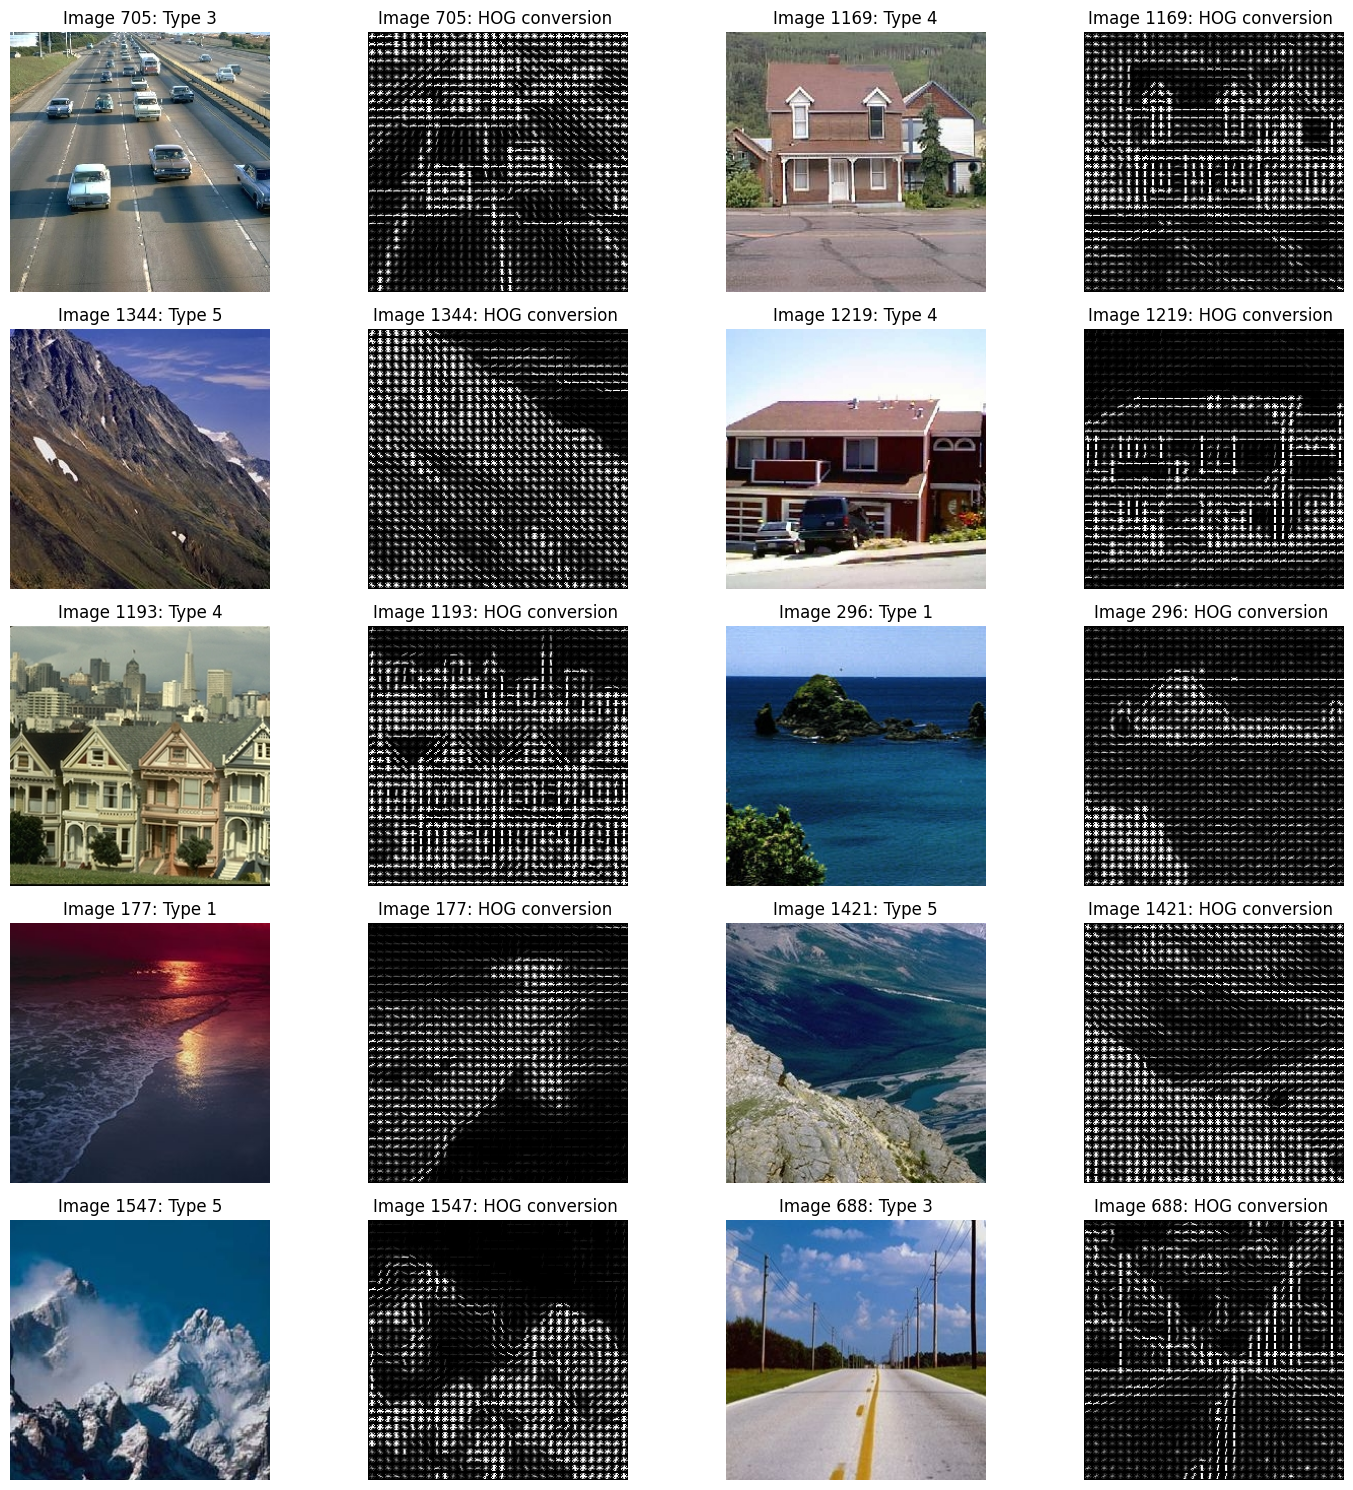

In [9]:
print(f"Original image shape : {images[0].shape}")
hog_f = hog_features(images[0])
print(f"HOG feature shape : {hog_f.shape}")

# ! The image was splited into 8x8 patches, and each patch has 9 features. Which means that in a 256x256 image, we would have (256/8)x(256/8)=1024 patches.
# ! The 9 features are the histogram of gradients for each patch where each value is the oriented gradient value in a certain range.
# ! For example with 9 features (orientation bins) we would have 180/9 = 20 degrees per bin. 
# ! So the first bin would represent the gradients from 0 to 20 degrees, the second from 20 to 40, etc.

# Show the first 10 scenes with their HOG features
print("10 random scenes with their labels and HOG features:")
plt.figure(figsize=(15, 15))
random_indexes = np.random.choice(len(images), size=10, replace=False)
for i, image_index in enumerate(random_indexes):
    # Original image
    plt.subplot(5, 4, 2 * i + 1)
    plt.imshow(images[image_index])
    # print(images[image_index].shape) # (256, 256, 3)
    plt.title(f"Image {image_index}: Type {labels[image_index]}")
    plt.axis('off')
    
    # HOG features
    plt.subplot(5, 4, 2 * i + 2)
    image_rescaled = hog_features(images[image_index], visualize=True)
    # print(image_rescaled.shape) # (256, 256) 
    hog_image_rescaled = exposure.rescale_intensity(image_rescaled, in_range=(0, 10))
    plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    plt.title(f"Image {image_index}: HOG conversion ")
    plt.axis('off')
plt.tight_layout()
plt.show()

**(Question)** Compute HOG features for the whole dataset. If it takes too long, you can directly load them from the provided `hog.tgz` file.

In [10]:
print(f"Number of images: {len(images)}")

# Computation of the HOG features for all the images
# hog_features_dataset = []
# for i in range(len(images)):
#     print(f"Image {i}/{len(images)}", end="\r")
#     hog_features_dataset.append([hog_features(images[i])])

# Loading the HOG features from hog.npy
hog_file = 'hog.npy'
hog_features_dataset = np.load(hog_file)
print(f"hog features : {hog_features_dataset.shape}")

Number of images: 2686
hog features : (2686, 1024, 9)


**(Question)** Split these features into train and test sets (for example 75% train, 25% test).

*Hint*: you can use the `train_test_split` method from `sklearn.model_selection`.

In [11]:
X_train_images, X_test_images, y_train, y_test = train_test_split(hog_features_dataset, labels, train_size=0.75, random_state=42)

print(f"Train images hog features : {X_train_images.shape}")
print(f"Test images hog features : {X_test_images.shape}")

X_train_hog_features = np.vstack(X_train_images)
print(f"Combined train hog features: {X_train_hog_features.shape}")

Train images hog features : (2014, 1024, 9)
Test images hog features : (672, 1024, 9)
Combined train hog features: (2062336, 9)


### 4. Bag of features

We will now implement the bag of features approach. It is composed on three main steps:
- Learn a vocabulary of visual words (also called codebook) using a clustering method (for example K-Means) applied on HOG features
- Project each feature of an image into the vocabulary, and build an histogram of these projections, giving a final single feature vector for the image
- Train an SVM classifier with these histograms of visual words as features for training images

**(Question)** Build the vocabulary of visual words with K-Means. The vocabulary size corresponds to the number of clusters.

In [12]:
from sklearn.cluster import MiniBatchKMeans, KMeans

def build_vocabulary(features, voc_size=100):
    # Cluster features into a visual vocabulary with K-Means algorithm,
    # then return the trained classified object.
    # You can use the MiniBatchKMeans class for very similar results 
    # but faster run time
    kmeans = KMeans(n_clusters=voc_size, random_state=42)
    # kmeans = MiniBatchKMeans(n_clusters=voc_size, random_state=42)
    kmeans.fit(features)
    return kmeans

In [13]:
# Build the vocabulary from train features
vocabulary = build_vocabulary(X_train_hog_features, voc_size=100)

In [14]:
assert vocabulary.n_clusters == 100
assert vocabulary.n_features_in_ == 9

**(Question)** Try to understand the `build_codebook` function below. Then, compute the histograms of visual words for features of the train and test sets. Store the results into `X_train` and `X_test` variables.

In [15]:
def build_codebook(features, vocabulary):
    # Given a vocabulary of visual words (KMeans classifier object),
    # compute the codebook (histogram) of the set of features for an image
    voc_size = len(vocabulary.cluster_centers_)
    codebook = np.zeros((len(features), voc_size))
    for i, f in enumerate(features):
        assignemnts = vocabulary.predict(f)
        for k in range(voc_size):
            codebook[i][k] = len(np.where(assignemnts == k)[0])
    codebook = codebook / codebook.sum(axis=1)[:, np.newaxis] # normalization
    return codebook

In [16]:
# Build the codebooks for train and test features into X_train and X_test variables respectively
X_train = build_codebook(X_train_images, vocabulary)
X_test = build_codebook(X_test_images, vocabulary)

print(f"codebook shape: {X_train.shape}")

codebook shape: (2014, 100)


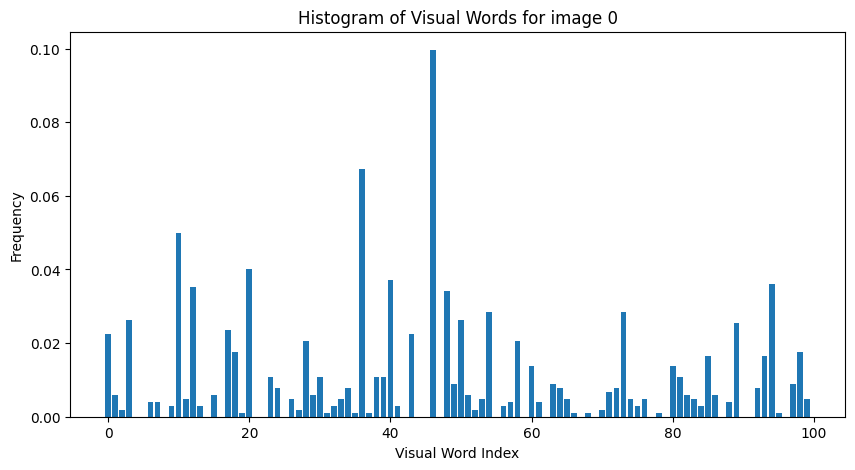

Top 10 visual words frequencies in image 0: [0.09960938 0.06738281 0.04980469 0.04003906 0.03710938 0.03613281
 0.03515625 0.03417969 0.02832031 0.02832031]. Total of top 10 frequencies is 45.61%
Top 10 visual words indexed in image 0: [46 36 10 20 40 94 12 48 54 73]


In [17]:
# Plotting histograms of the codebook
def plot_histogram_of_words(image_histogram, title="Histogram of Visual Words"):
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(image_histogram)), image_histogram)
    plt.xlabel('Visual Word Index')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()


# Plotting histogram of the first image in the training set
plot_histogram_of_words(X_train[0], title="Histogram of Visual Words for image 0")

X_train_0_sorted_index = np.argsort(X_train[0])[::-1]
X_train_0_sorted = np.sort(X_train[0])[::-1]
print(f"Top 10 visual words frequencies in image 0: {X_train_0_sorted[:10]}. Total of top 10 frequencies is {np.sum(X_train_0_sorted[:10])*100:.2f}%")
print(f"Top 10 visual words indexed in image 0: {X_train_0_sorted_index[:10]}")

This histogram shows the percentage of patches in each of the 100 clusters for image 0.

In [18]:
assert X_train.shape == (y_train.shape[0], 100)
assert X_test.shape == (y_test.shape[0], 100)

**(Question)** Explain what the `build_codebook` function does.

The function `build_codebook` generates a list of values (histogram) that holds the percentage of patches that fall in the respective clusters. The clusters were created using the unsupervised technique of Kmeans. Kmeans is also responsable for the attribution of each patch to it's cluster.

To be more precise, the function first generates a list of word attributions for each hog feature in features it takes as an input, for example, the word attributions (assignments) for a certain image would be [42,0,....] which implies that the hog features of the first patch of the image fits in the category of the words 42 and the hog features of the second patch of the image fits in the category of the words 0 and same goes for the rest of the patches in an image. This tensor is then used to count the number of patches in each word category and normalizes them over all categories. Thus giving as an output a histogram of words (codebook).

**(Question)** Train an SVM classifier with the histograms of visual words and report the classification results. Analyze the results and try to improve the classification results by adjusting the hyperparameters.

#### Testing default SVM on scenes

In [19]:
n_splits = 10
cross_validator = KFold(n_splits=n_splits)

classifier = SVC() # All default parameters (kernel='rbf', C=1.0, ...)

scores = run_cross_validation(X_train, y_train, cross_validator, classifier)
print(f"Cross-validation scores: {scores}")
print(f"RBF SVM mean accuracy: {np.mean(scores) * 100:.2f}% +-{np.std(scores) * 100:.2f}%")

Cross-validation scores: [0.7821782178217822, 0.7722772277227723, 0.7425742574257426, 0.801980198019802, 0.7164179104477612, 0.7412935323383084, 0.8009950248756219, 0.7313432835820896, 0.736318407960199, 0.7512437810945274]
RBF SVM mean accuracy: 75.77% +-2.84%


In [20]:
from sklearn.metrics import accuracy_score

# Train the SVM classifier with default parameters
svm = SVC()
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# Report the classification results
print("Classification Results (Default SVM):")
print(f"Accuracy on test set after testing on all train dataset: {accuracy_score(y_test, y_pred) * 100:.3f}%")

Classification Results (Default SVM):
Accuracy on test set after testing on all train dataset: 78.125%


Both the cross-validation scores and the scores from testing directly on the test dataset are quite similar. The accuracy is around 75%, which is not satisfactory. Let's try to improve our SVM model.

#### Finding the best combination of hyperparameters for SVM classifier on scenes

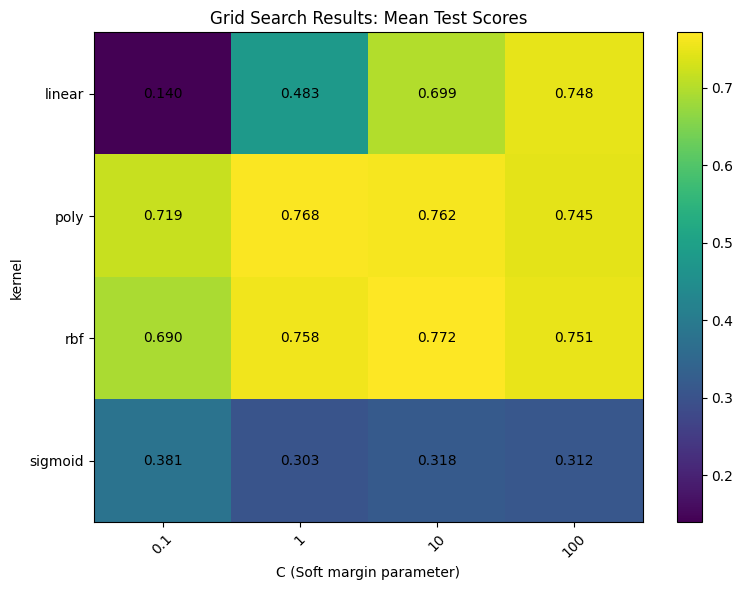

Best parameters: {'C': 10, 'kernel': 'rbf'}
Best score: 0.7715629771932416


In [21]:
grid_search_params = {
    'C' : [0.1, 1, 10, 100],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
}
param1_size = len(grid_search_params['C'])
param2_size = len(grid_search_params['kernel'])

classifier = SVC()
grid_search = GridSearchCV(classifier, grid_search_params, cv=cross_validator)
grid_search.fit(X_train, y_train)

# Plotting the results of the grid search
scores = grid_search.cv_results_['mean_test_score'].reshape(param1_size, param2_size).T

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(scores, cmap='viridis', aspect='auto')
fig.colorbar(cax)
ax.set_xticks(np.arange(param1_size))
ax.set_yticks(np.arange(param2_size))
ax.set_xticklabels(grid_search_params['C'])
ax.set_yticklabels(grid_search_params['kernel'])
plt.xticks(rotation=45)
for i in range(param2_size):
    for j in range(param1_size):
        ax.text(j, i, f'{scores[i, j]:.3f}', ha='center', va='center', color='black')
ax.set_xlabel('C (Soft margin parameter)')
ax.set_ylabel('kernel')
ax.set_title('Grid Search Results: Mean Test Scores')
plt.tight_layout()
plt.show()

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Fine hyperparameter tuning for rbf kernel

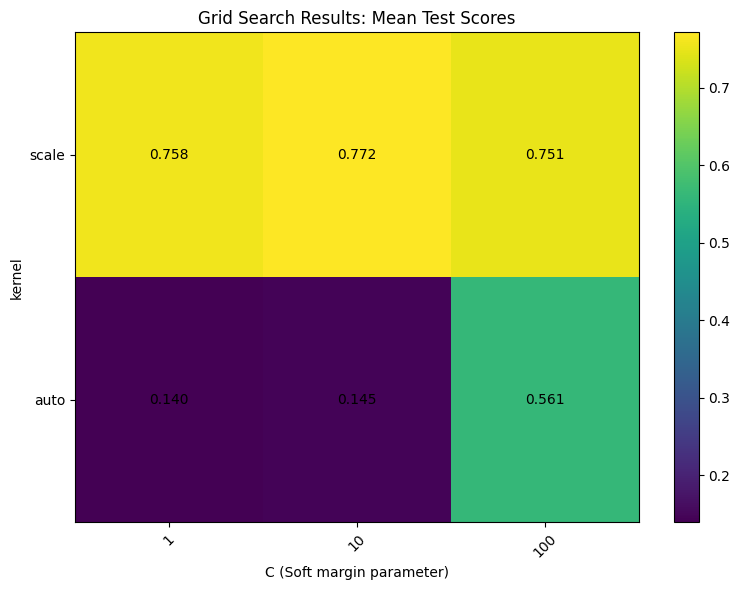

Best parameters: {'C': 10, 'gamma': 'scale'}
Best score: 0.7715629771932416


In [22]:
grid_search_params = {
    'C' : [1, 10, 100],
    'gamma': ['scale', 'auto']
}
param1_size = len(grid_search_params['C'])
param2_size = len(grid_search_params['gamma'])

classifier = SVC(kernel='rbf')
grid_search = GridSearchCV(classifier, grid_search_params, cv=cross_validator)
grid_search.fit(X_train, y_train)

# Plotting the results of the grid search
scores = grid_search.cv_results_['mean_test_score'].reshape(param1_size, param2_size).T

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(scores, cmap='viridis', aspect='auto')
fig.colorbar(cax)
ax.set_xticks(np.arange(param1_size))
ax.set_yticks(np.arange(param2_size))
ax.set_xticklabels(grid_search_params['C'])
ax.set_yticklabels(grid_search_params['gamma'])
plt.xticks(rotation=45)
for i in range(param2_size):
    for j in range(param1_size):
        ax.text(j, i, f'{scores[i, j]:.3f}', ha='center', va='center', color='black')
ax.set_xlabel('C (Soft margin parameter)')
ax.set_ylabel('kernel')
ax.set_title('Grid Search Results: Mean Test Scores')
plt.tight_layout()
plt.show()

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

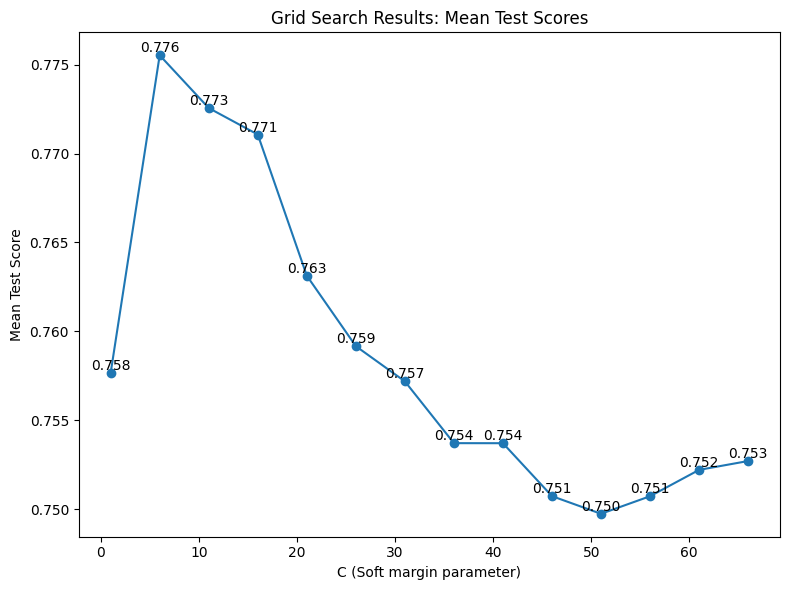

Best parameters: {'C': 6}
Best score: 0.7755282990985666


In [23]:
# Define grid search parameters
grid_search_params = {
    'C': np.arange(1, 70, 5)
}
param1_size = len(grid_search_params['C'])

# Initialize classifier
classifier = SVC(kernel='rbf')

# Set up grid search
grid_search = GridSearchCV(classifier, grid_search_params, cv=cross_validator)
grid_search.fit(X_train, y_train)

# Plotting the results of the grid search
scores = grid_search.cv_results_['mean_test_score']

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(grid_search_params['C'], scores, marker='o', linestyle='-')
ax.set_xlabel('C (Soft margin parameter)')
ax.set_ylabel('Mean Test Score')
ax.set_title('Grid Search Results: Mean Test Scores')

# Annotating the plot with score values
for i, score in enumerate(scores):
    ax.text(grid_search_params['C'][i], score, f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

From applying cross-validation on multiple combinations of hyperparameters, we can conclude that the best SVM model to uses ios with the "rbf" kernel with a soft margin parameter of approximately 10. It achieves an accuracy of 78.7% on the test dataset.

#### Testing SVM with the best hyperparameters

In [24]:
cross_validator = KFold(n_splits=10)

classifier = SVC(kernel='rbf', C=10, gamma='scale')

scores = run_cross_validation(X_train, y_train, cross_validator, classifier)
print(f"Cross-validation scores: {scores}")
print(f"RBF SVM mean accuracy: {np.mean(scores) * 100:.2f}% +-{np.std(scores) * 100:.2f}%")

classifier = SVC(kernel='rbf', C=10, gamma='scale')
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Report the classification results
print("Classification Test Results (Default SVM):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Cross-validation scores: [0.7623762376237624, 0.7871287128712872, 0.7920792079207921, 0.8168316831683168, 0.6766169154228856, 0.7860696517412935, 0.7810945273631841, 0.7512437810945274, 0.7860696517412935, 0.7761194029850746]
RBF SVM mean accuracy: 77.16% +-3.57%
Classification Test Results (Default SVM):
Accuracy: 0.7842


**(Question)** Propose a visualization of some of the visual words learned by your bag of features model.

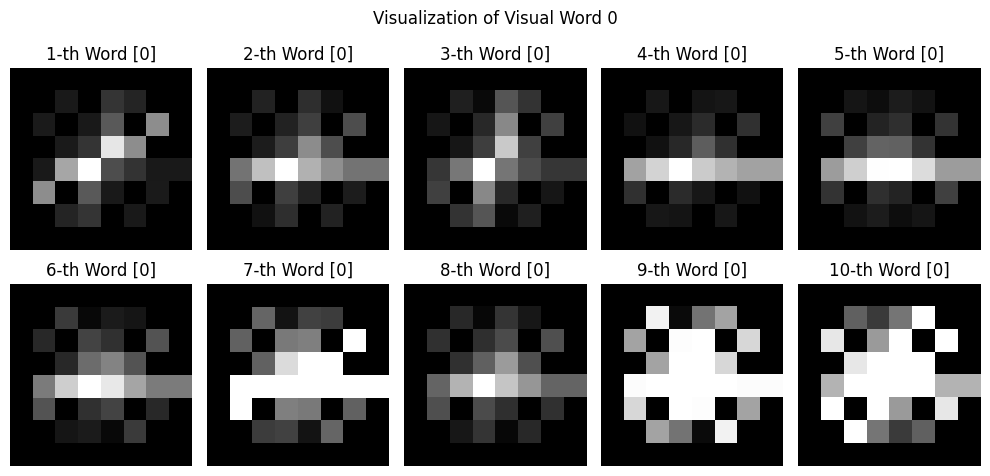

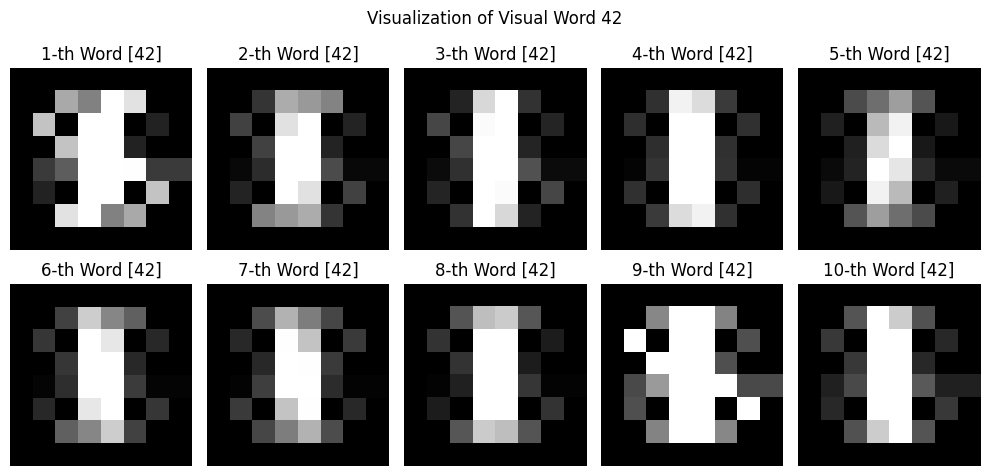

In [25]:
def plot_visual_words(images, vocabulary, num_patches=10, select_word=32):
    vis_hog_f = []
    
    for _ in range(num_patches):
        image_index = np.random.randint(len(images))
        image = images[image_index]
        
        # Compute HOG features for the image
        hog_f = hog_features(image)
        visual_hog_f = hog_features(image, visualize=True)

        # Predict the visual words for the HOG features
        visual_words = vocabulary.predict(hog_f)
        
        for i in range(len(visual_words)):
            if visual_words[i] == select_word and len(vis_hog_f) < num_patches:
                patch_row = (i // (image.shape[1] // 8)) * 8
                patch_col = (i % (image.shape[1] // 8)) * 8
                vis_hog_f.append(visual_hog_f[patch_row:patch_row + 8, patch_col:patch_col + 8])

    # Plot the HOG features of the visual word 
    plt.figure(figsize=(10, 5))
    for i, word in enumerate(vis_hog_f):
        hog_image = exposure.rescale_intensity(word, in_range=(0, 10))
        plt.subplot(2, 5, i+1)
        plt.imshow(hog_image, cmap=plt.cm.gray)
        plt.title(f"{i+1}-th Word [{select_word}]")
        plt.axis('off')
    plt.suptitle(f"Visualization of Visual Word {select_word}")
    plt.tight_layout()
    plt.show()

# Plot visual words for 10 random patches
plot_visual_words(images, vocabulary, num_patches=10, select_word=0)
plot_visual_words(images, vocabulary, num_patches=10, select_word=42)

Above, we can see how patches from the same clusters are similar to one another, as well as how different they are compared to patches from other clusters, specifically cluster 0 and cluster 42.

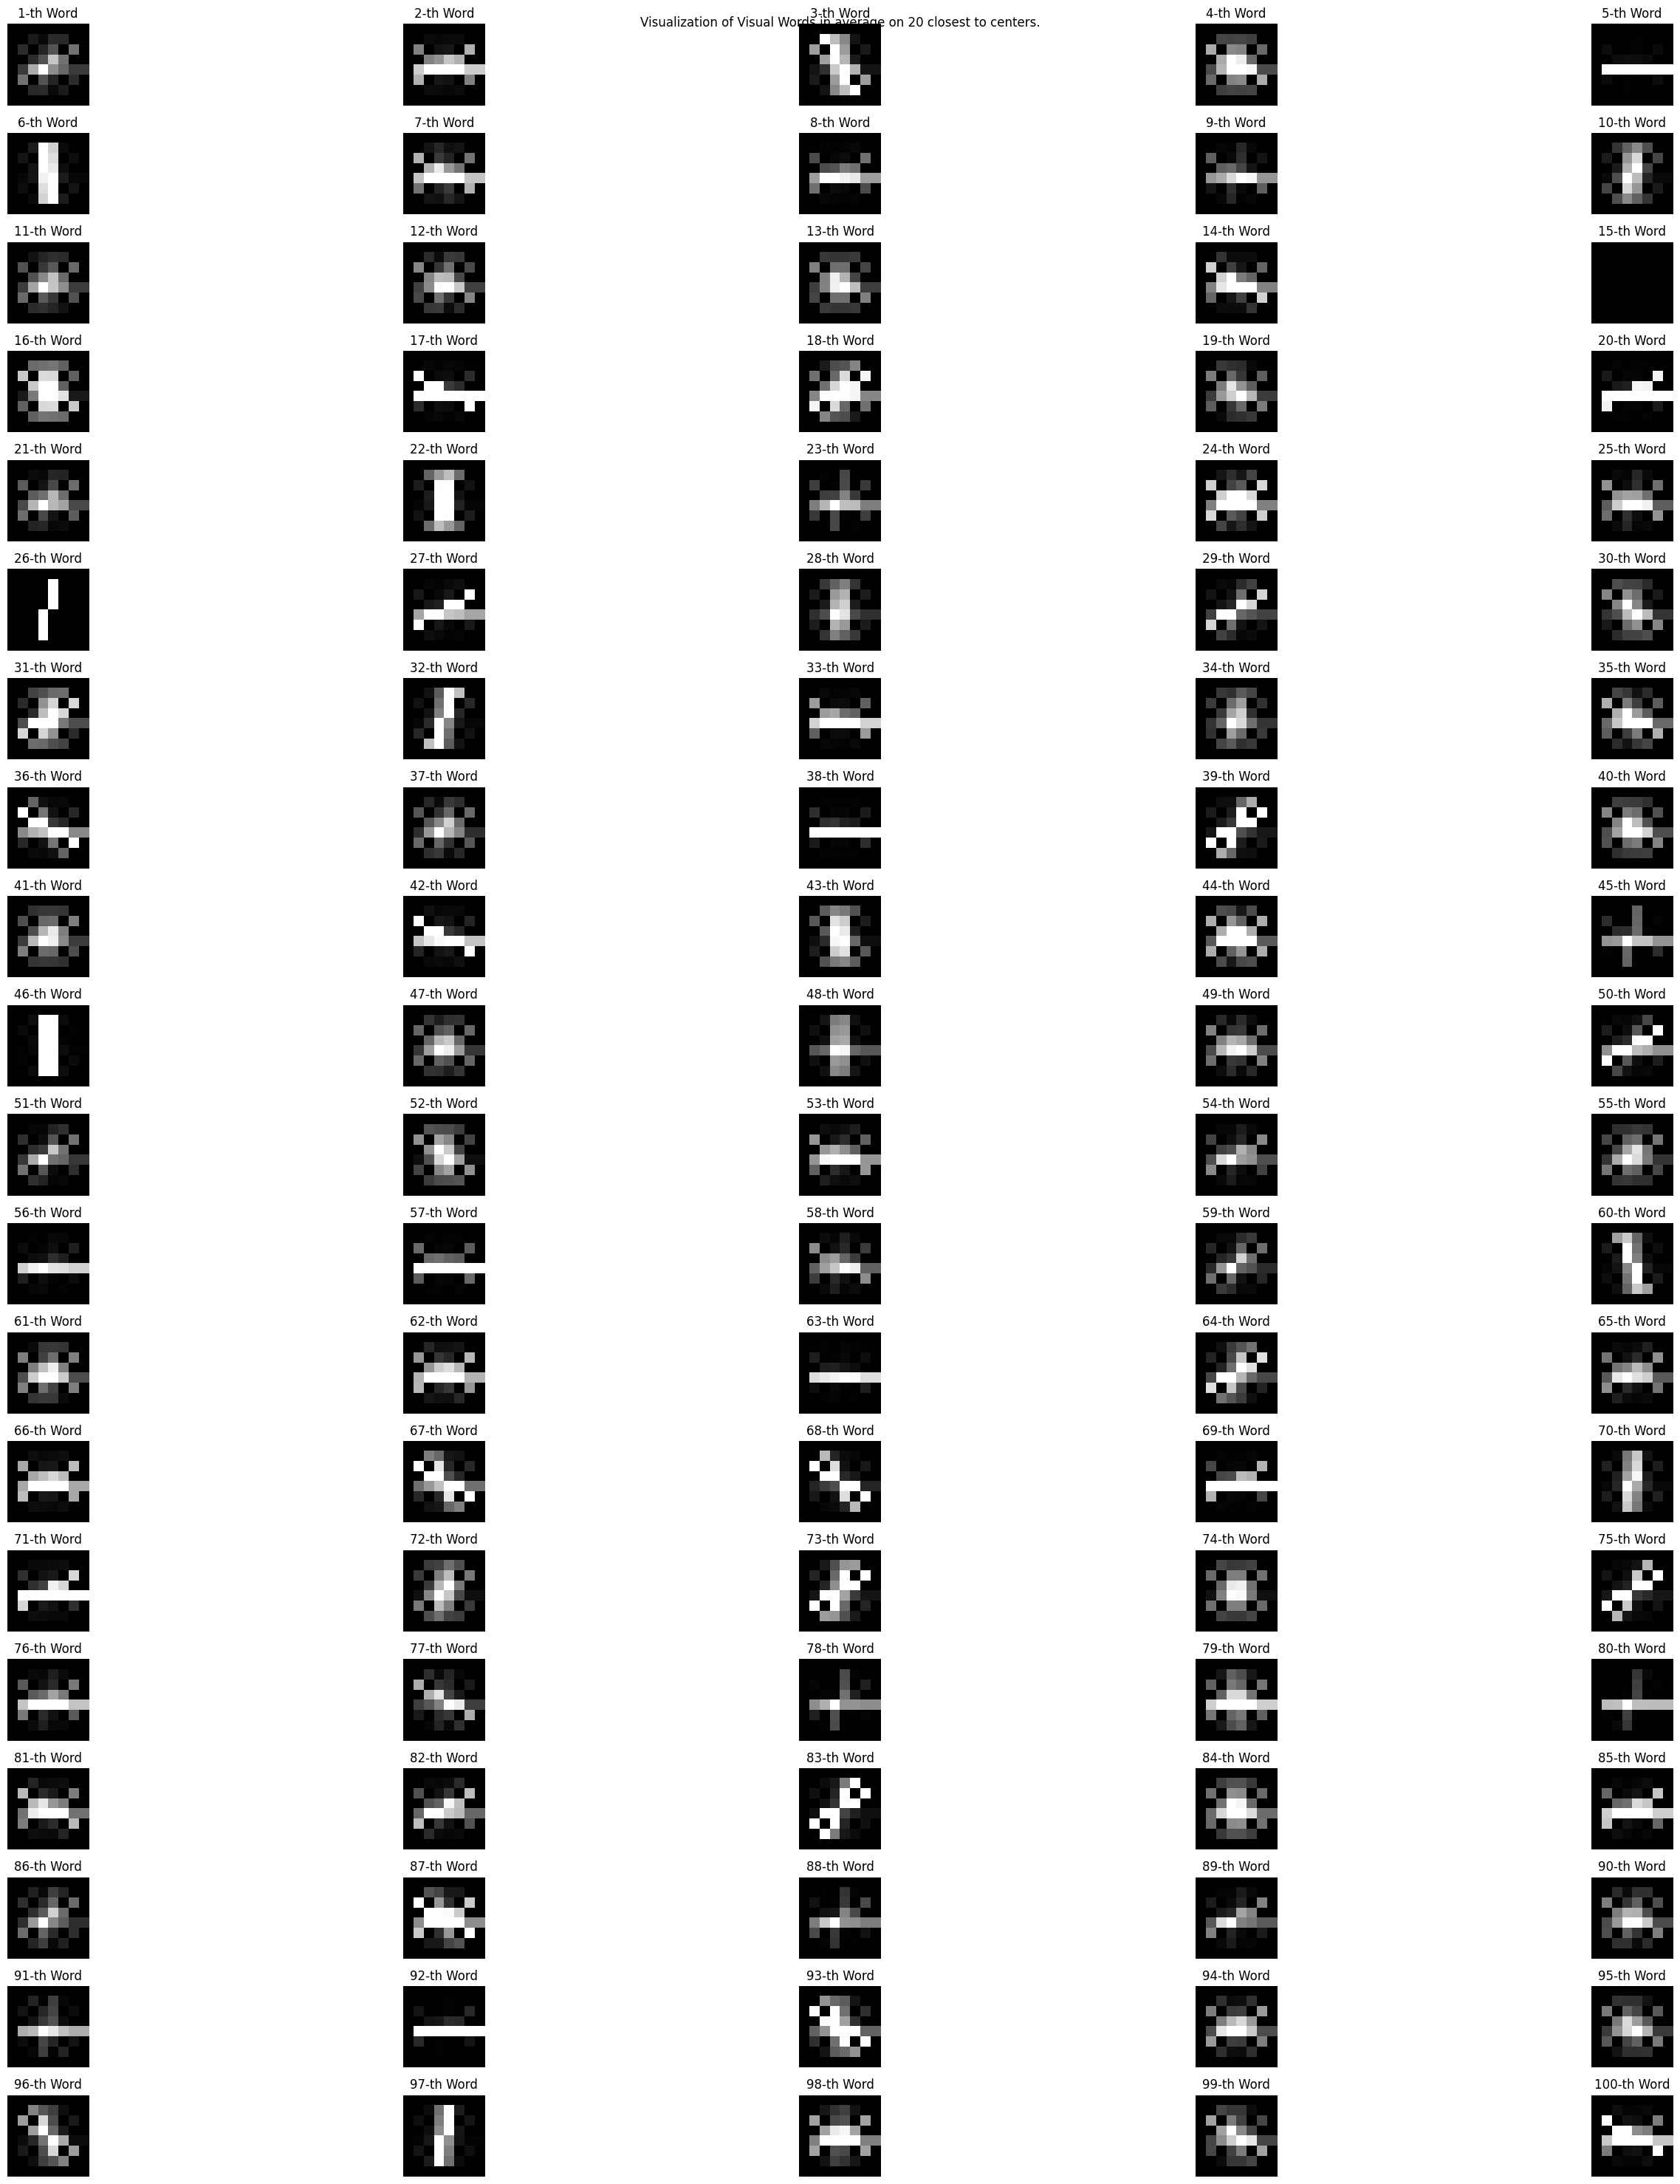

In [26]:
def plot_average_visual_words(images, vocabulary, num_patches=10, n_closest=10):
    vis_hog_distances = {}
    vis_hog_images = {}

    for i in range(vocabulary.n_clusters):
        vis_hog_distances[i] = []
        vis_hog_images[i] = []

    cluster_centers = vocabulary.cluster_centers_

    u = 0
    for image in images:
        u += 1
        print(f"Image {u}/{len(images)}...", end="\r")

        # Compute distances from each image's HOG features to the centroid
        hog_f = hog_features(image)
        visual_words = vocabulary.predict(hog_f)
        visual_hog_f = hog_features(image, visualize=True)
        
        for i in range(len(visual_words)):
            word = visual_words[i]
            vector = hog_f[i]

            distance = np.linalg.norm(cluster_centers[word] - vector)
            vis_hog_distances[word].append(distance)
            
            patch_row = (i // (image.shape[1] // 8)) * 8
            patch_col = (i % (image.shape[1] // 8)) * 8
            vis_hog_images[word].append(visual_hog_f[patch_row:patch_row + 8, patch_col:patch_col + 8])

    for i in range(vocabulary.n_clusters):
        indexes_sort = np.argsort(vis_hog_distances[i])
        vis_hog_distances[i] = np.array(vis_hog_distances[i])[indexes_sort]
        vis_hog_images[i] = np.array(vis_hog_images[i])[indexes_sort]

    # average on num_patches closest
    vis_hog_images_average = {}
    for i in range(vocabulary.n_clusters):
        vis_hog_images_average[i] = np.mean(vis_hog_images[i][:num_patches], axis=0)

    lenn = vocabulary.n_clusters
    cols = 5 
    rows = (lenn + cols - 1) // cols  
    
    # Plot the HOG features of the visual word 
    plt.figure(figsize=(30, 30))
    for i in vis_hog_images_average.keys():
        word = vis_hog_images_average[i]
        hog_image = exposure.rescale_intensity(word, in_range=(0, 10))
        plt.subplot(rows, cols, i + 1)  # i starts from 0
        plt.imshow(hog_image, cmap=plt.cm.gray)
        plt.title(f"{i+1}-th Word")
        plt.axis('off')
    plt.suptitle(f"Visualization of Visual Words in average on {num_patches} closest to centers.")
    plt.tight_layout()
    plt.show()
        
# Call the function to plot average visual words
plot_average_visual_words(images[:50], vocabulary, num_patches=20, n_closest=10)

Above, we can see the 100 word bags along with an average representation of each based on the 20 closest patches from a subset of the dataset, as running the analysis on the entire dataset would be too lengthy. Once again, we observe how different each cluster or word is from one another; however, there are some similarities between certain clusters. This could explain the low score of our SVM model previously, as the closer the words are to each other, the more challenging the classification becomes.

#### (Bonus) Finding the optimal vocabulary size using the elbow method


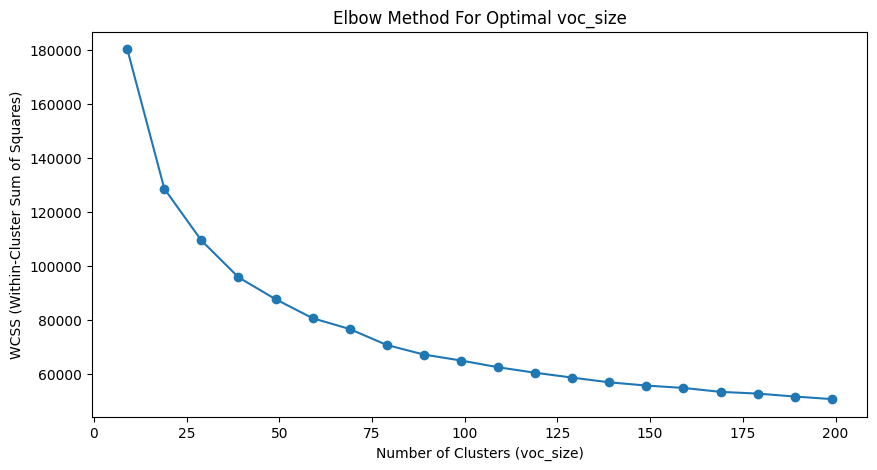

In [27]:
def build_vocabulary(features, voc_size=100):
    # Cluster features into a visual vocabulary with K-Means algorithm,
    # then return the trained classified object.
    # You can use the MiniBatchKMeans class for very similar results 
    # but faster run time
    # kmeans = KMeans(n_clusters=voc_size, random_state=42)
    kmeans = MiniBatchKMeans(n_clusters=voc_size, random_state=42)
    kmeans.fit(features)
    return kmeans

def wcss_kmeans(voc_size=100):
    # Build the vocabulary from train features
    vocabulary = build_vocabulary(X_train_hog_features, voc_size)
    return vocabulary.inertia_

wcss = [wcss_kmeans(voc_size) for voc_size in range(9, 200, 10)]


plt.figure(figsize=(10, 5))
plt.plot(range(9, 200, 10), wcss, marker='o')
plt.xlabel('Number of Clusters (voc_size)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method For Optimal voc_size')
plt.show()

We plot the WCSS cores for each number of clusters (vocabulary size) in hope to see a clear elbow point which is a point where the wcss curve changes its derivatives quickly thus allowing us to see a clear point where the curve breaks.

In our case, no clear elbow point is visible which means that we need to try another method to find the optimal number of clusters (vocabulary size) like the silhouette score method which measures how close a point is to its nearest neighbor points, across all clusters. This method gives us a clear information about the clustering quality.